# Image Classifier application
### Deep Learning, Transfer Learning

A flower classification application has been created using a deep neural network with a pretrained VGG16 Model using transfer learning. The prediction accuarcy is 86% <br>
The following code shows data cleaning, preprocessing along with training and testing steps. 
A running application can be found in the python files found in this folder which can be run from command line.
<hr>

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
from collections import OrderedDict
from PIL import Image
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load data


In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# load Dataset
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Define dataloaders = 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Label mapping

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


In [5]:
print(len(cat_to_name));

102


# Building and training the classifier

Training the classifier would be done using transfer learning. VGG16 Model

In [6]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:20<00:00, 27660806.61it/s]


In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
input_features=model.classifier[0].in_features
print(input_features)

25088


In [9]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [10]:
# Configuring our classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_features, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [11]:
model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

## Testing network

In [12]:
# Putting the above into functions, so they can be used later

def do_deep_learning(model, trainloader, epochs, print_every, criterion, optimizer, device='cpu'):
    epochs = epochs
    print_every = print_every
    steps = 0

    # change to cuda
    model.to('cuda')

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0
                print('Checking accuracy using Validate dataset')
                check_validation_accuracy(validloader)
            
    
def check_accuracy(testloader):
    model.to('cuda')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network: %d %%' % (100 * correct / total))
    model.train()

def check_validation_accuracy(testloader):
    model.to('cuda')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = (criterion(outputs, labels) / total)

    print('Accuracy of the validation set: %d %%' % (100 * correct / total))
    print('Loss of the validation set is:', loss)
    model.train()

In [13]:
do_deep_learning(model, trainloader, 3, 40, criterion, optimizer, 'gpu')

Epoch: 1/3...  Loss: 3.2759
Checking accuracy using Validate dataset
Accuracy of the validation set: 63 %
Loss of the validation set is: tensor(1.00000e-03 *
       1.8093, device='cuda:0')
Epoch: 1/3...  Loss: 1.6089
Checking accuracy using Validate dataset
Accuracy of the validation set: 74 %
Loss of the validation set is: tensor(1.00000e-03 *
       1.0182, device='cuda:0')
Epoch: 2/3...  Loss: 0.4771
Checking accuracy using Validate dataset
Accuracy of the validation set: 83 %
Loss of the validation set is: tensor(1.00000e-04 *
       6.6001, device='cuda:0')
Epoch: 2/3...  Loss: 0.9232
Checking accuracy using Validate dataset
Accuracy of the validation set: 83 %
Loss of the validation set is: tensor(1.00000e-04 *
       1.3109, device='cuda:0')
Epoch: 2/3...  Loss: 0.9233
Checking accuracy using Validate dataset
Accuracy of the validation set: 84 %
Loss of the validation set is: tensor(1.00000e-04 *
       3.8745, device='cuda:0')
Epoch: 3/3...  Loss: 0.6868
Checking accuracy usin

In [14]:
# Accuracy of test data
check_accuracy(testloader)

Accuracy of the network: 86 %


## Save - Checkpoint


In [15]:
#print("Our model: \n\n", model, '\n')
#print("The state dict keys: \n\n", model.state_dict().keys())

In [16]:
# Saving the entire model since it has been trained. I no longer need to configure/relearn it, hence not saving any other parameters

model.class_to_idx = train_data.class_to_idx
checkpoint = {'model': model,
              'state_dict': model.state_dict()}

In [17]:
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint


In [18]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])   
    return model

In [19]:
model = load_checkpoint('checkpoint.pth')

In [20]:
#model

# Inference for classification


## Image Preprocessing

Following steps have been done:
   - Loading the image using 'PIL'
   - Resizing the images to 256 pixels
   - Crop the center to 224 x 224 pixels
   - Normalize the images
   - Reorder dimensions so that they could be inputted into pytorch properly

In [21]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    img_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    image_processed = img_transforms(img)    
    return image_processed.numpy()

In [22]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

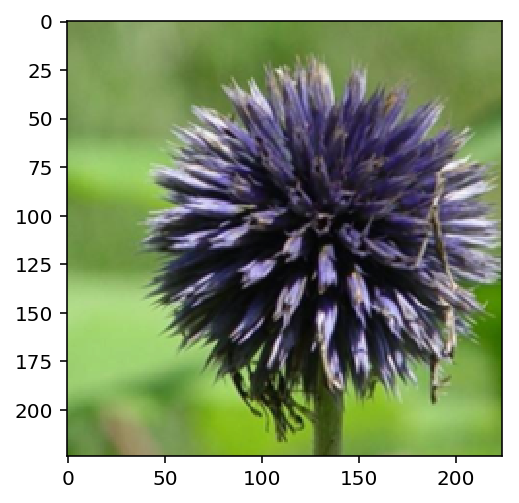

In [23]:
img = (data_dir + '/test' + '/10/' + 'image_07104.jpg')
#print(img)
img = process_image(img)
#print(img)
imshow(img)

## Class Prediction

Predict top 5 classes

In [24]:
# Sample code to check if functions work
#dataiter = iter(testloader)
#images, labels = dataiter.next()
#print(images)
#img = images[3]
#print(img)
#imshow(img.numpy())

In [25]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''    
    #Render model
    model = load_checkpoint('checkpoint.pth')
    # print(model)
    model.to('cuda')
    # Render image
    img = process_image(image_path)
    img = torch.FloatTensor(img).unsqueeze(0)
    img = img.to('cuda')

    model.eval()
    with torch.no_grad():
        output = model.forward(img)
    output = torch.exp(output)
    #print(output[0].sum())
    prob = np.array(output.topk(topk)[0])[0]
    labels = np.array(output.topk(topk)[1])[0]

    class_to_idx = model.class_to_idx
    indx_to_class = {x: y for y, x in class_to_idx.items()}

    classes = []
    for index in labels:
        classes += [indx_to_class[index]]
    
    return prob, classes

In [26]:
model_path = 'checkpoint.pth'
img = (data_dir + '/test' + '/16/' + 'image_06670.jpg')
image_path = img

In [27]:
probs,classes = predict(image_path, model_path, topk=5)
print(probs, classes)

[ 0.90426815  0.04264192  0.01299823  0.00810208  0.00372883] ['16', '97', '96', '89', '42']


## Sanity Checking

Check whether trained model makes sense when it predicts. Show image aswell.

In [28]:
names = []
for i in classes:
    names += [cat_to_name[i]]

In [29]:
image = Image.open(image_path)

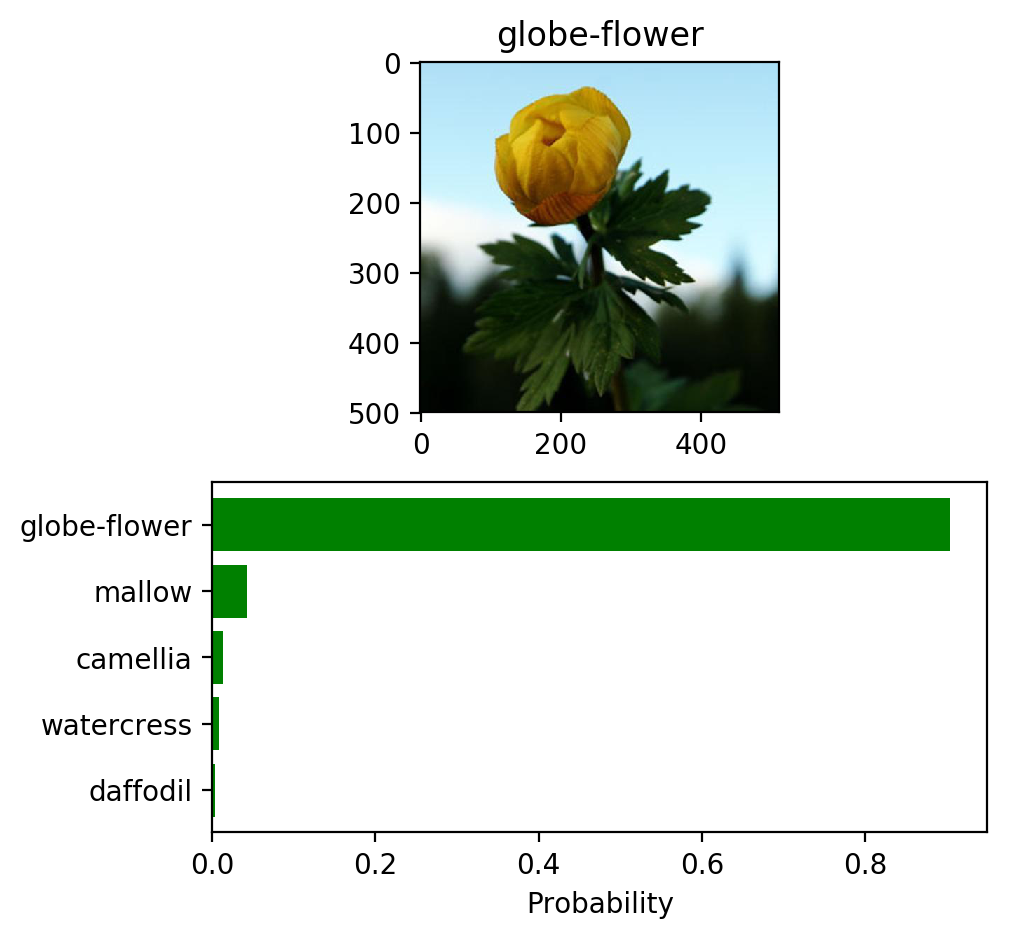

In [30]:
plt.rcdefaults()
fig, ax = plt.subplots(2, figsize = (5,5))

ax[0].imshow(image)
ax[0].set_title(names[0])

y_pos = np.arange(len(names))
ax[1].barh(y_pos, probs, align='center',
        color='green', ecolor='black')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis() 
ax[1].set_xlabel('Probability')

plt.show()